# <font color=#cd0000> Propósito principal </font>
- La idea de este librillo es preparar el entorno para realizar pruebas para Seguimiento Ocular a ser clasificado con la Tendencia por RF

## <font color=#cd0000> Leyenda </font>
- Los apartados titulados con el código de colores HEX: `#cd0000` serán apartados que tendrán todos los librillos, en concreto, aquellos especificados en el apartado `Síntesis de los criterios usados` del trabajo.
- Los apartados titulados con el código de colores HEX: `#2451ff` serán apartados de conclusiones propias de este librillo resultado de aplicar un estudio personalizado para cada planteamiento.

# <font color=#cd0000> Prerrequisitos </font>
## <font color=#cd0000> Entorno de ejecución </font>
- Cambiamos el directorio raíz del librillo para acceder cómodamente a las funciones de utilidad.

In [1]:
import os

os.chdir('../../../../')
os.listdir()


['.git',
 '.gitignore',
 '.gitmodules',
 'data',
 'HeartBeat_tmp_test_data.pkl',
 'HeartBeat_tmp_train_data.pkl',
 'pkl',
 'Pruebas',
 'README.md',
 'smts_implementation',
 'utils']

## <font color=#cd0000> Constantes y variables predefinidas </font>

In [2]:
SEGUIMIENTO_OCULAR_PATH = "data/seguimiento-ocular/Data/Hospital"
SEGUIMIENTO_OCULAR_FOLDERS_ID = range(1, 12+1)

DATA_TO_SAVE = "SegOcular"

PKL_DIR = "pkl/RF/SegOcular/"
PKL_NAME = "segocular_RF_trend.pkl"

SEED = 1


# <font color=#cd0000> Carga del Dataset </font>

In [3]:
from utils.load_data import import_seguimiento_ocular_dataset

all_data = import_seguimiento_ocular_dataset(
    SEGUIMIENTO_OCULAR_PATH, SEGUIMIENTO_OCULAR_FOLDERS_ID)


In [4]:
all_data.reset_changes()


# <font color=#cd0000> Preprocesamiento </font>

## <font color=#cd0000> Eliminación de datos inválidos y valores atípicos </font>
- No eliminaremos aquellos valores fuera de los percentiles 5 y 95 ante la falta de información.

### <font color=#2451ff> Limpieza de datos </font>
- Eliminaremos todos aquellos valores inválidos con un "0" en alguna de las columnas `*Validity*`.

In [5]:
# Clean data
validity_headers = ['ValidityLeft',
                    'ValidityRight',
                    'PupilValidityLeft',
                    'PupilValidityRight']

all_data.clean_data(criterion='remove', value=0, headers=validity_headers)

## <font color=#2451ff> Reducción de la dimensionalidad </font>
- Eliminamos los atributos de validez y los redundantes/no informativos (o que puedan sesgar al modelo).

In [6]:
# Reduce data
columns_to_remove = validity_headers + ['GazePointX', 'GazePointY',
                                        'diagnosis', 'Age']

all_data.drop_derived_data_columns(columns_to_remove)


,id,TimeStamp,GazePointXLeft,GazePointYLeft,GazePointXRight,GazePointYRight,PupilSizeLeft,PupilSizeRight,class
0,1-1,704.487,875,549,771,284,2.1565,2.1575,Control
1,1-1,750.040,879,519,796,245,2.0449,2.1528,Control
2,1-1,776.032,898,547,785,316,2.1199,2.1833,Control
3,1-1,831.135,882,563,768,322,2.1039,2.3215,Control
4,1-1,857.075,879,513,789,362,2.0490,2.4636,Control
...,...,...,...,...,...,...,...,...,...
36362,12-3,54379.209,162,808,263,944,2.6453,2.4885,Estudio
36363,12-3,54406.850,136,816,272,969,2.6189,2.4906,Estudio
36364,12-3,54433.946,122,942,191,854,2.5684,2.2774,Estudio
36365,12-3,54460.926,326,918,364,936,2.3562,2.6705,Estudio


## <font color=#2451ff> Eliminación de series cortas </font>
- Ante la limpieza de los datos hemos acabado con series, concretamente, la ``8-1`` (72 muestras) y ``8-2`` (202 muestras), con muy pocas muestras.
  - Las eliminaremos con el fin de no obtener ventanas demasiado pequeñas (72/4 = 18 muestras por ventana)

In [7]:
all_data.derived_data = all_data.derived_data[
    all_data.derived_data['id'] != '8-1']  # 72 samples
all_data.derived_data = all_data.derived_data[
    all_data.derived_data['id'] != '8-2']  # 202 samples


In [8]:
import pandas as pd

# Remaining series
print("Previous number of series: {}".format(
    len(pd.unique(all_data.original_data['id']))))
print("Actual number of series: {}".format(
    len(pd.unique(all_data.derived_data['id']))))

print("Previous largest serie: {}".format(
    all_data.get_largest_serie(all_data.original_data).shape[0]))
print("Actual largest serie: {}".format(
    all_data.get_largest_serie().shape[0]))

print("Previous shortest serie: {}".format(
    all_data.get_shortest_serie(all_data.original_data).shape[0]))
print("Actual shortest serie: {}".format(
    all_data.get_shortest_serie().shape[0]))


Previous number of series: 25
Actual number of series: 23
Previous largest serie: 2113
Actual largest serie: 1901
Previous shortest serie: 967
Actual shortest serie: 768


## <font color=#cd0000> Resoluciones a aplicar </font>
- Como vimos en el análisis en profundidad, mantendremos la resolución actual

In [9]:
# Nothing to see here

# <font color=#cd0000> División en ventanas </font>
- El número de ventanas por serie será de 4 como ya vimos en el análisis en profundidad.

In [10]:
all_data.split_into_windows(n_windows=4)

# <font color=#2451ff> Particionado inicial de los datos </font>
- Llevaremos a cabo el particionado empleado por Marta en su TFM: http://hdl.handle.net/10486/697441

In [11]:
from utils.data_extraction import Data

X_train, X_test, _, _ = all_data.train_test_split(
    criterion='tfm_marta',
    train_size=.8,
    random_state=SEED,
    drop_columns=[]
)

X_train_Data = Data(X_train)
X_test_Data = Data(X_test)

In [12]:
X_train_Data.get_derived_data_classes_count()

Estudio    45
Control    24
Name: class, dtype: int64

In [13]:
X_test_Data.get_derived_data_classes_count()

Estudio    15
Control     8
Name: class, dtype: int64

## <font color=#cd0000> Codificación </font>

In [14]:
from utils.codifications import temporal_trend_fn

X_train_Data.apply_codifications([temporal_trend_fn])
X_test_Data.apply_codifications([temporal_trend_fn])

# <font color=#cd0000> Preparación de los datos </font>

In [15]:
X_train = X_train_Data.derived_data.drop(['id', 'class'], axis=1)
X_test = X_test_Data.derived_data.drop(['id', 'class'], axis=1)

y_train = X_train_Data.derived_data['class'].to_numpy()
y_test = X_test_Data.derived_data['class'].to_numpy()


## <font color=#cd0000> Técnicas de balanceo </font>

### <font color=#cd0000> Asignación de pesos a las clases </font>

In [16]:
import numpy as np
from sklearn.utils import compute_class_weight

class_weights = compute_class_weight(
    'balanced', classes=np.unique(y_train), y=y_train)
class_weights = {'Control': class_weights[0], 'Estudio': class_weights[1]}


# <font color=#cd0000> Diseño de la topología del bosque </font>
- Número de estimadores inicial recomendado
- Profundidad máxima recomendada

## <font color=#cd0000> Entrenamiento </font>

In [27]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=SEED,
    class_weight=class_weights
)
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight={'Control': 1.3592379800423344,
                                     'Estudio': 0.7909554812598979},
                       max_depth=10, random_state=1)

## <font color=#cd0000> Clasificación </font>

In [28]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

y_pred = clf.predict(X_test)
y_true = np.asarray(y_test)
    
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, zero_division=0))


[[1853 1454]
 [1020 4663]]
              precision    recall  f1-score   support

     Control       0.64      0.56      0.60      3307
     Estudio       0.76      0.82      0.79      5683

    accuracy                           0.72      8990
   macro avg       0.70      0.69      0.70      8990
weighted avg       0.72      0.72      0.72      8990



## <font color=#cd0000> Discusión de los resultados </font>
- Vamos a estudiar diferentes rangos de hiper-parámetros interesantes que podrían darnos alguna pista sobre el rango en el que buscar el mejor clasificador de este tipo:
  - Para un `n_estimators` pequeño (10) y una `max_depth` pequeño (10) no observamos una mejora notable con respecto a la clasificación sobre series en bruto:
    ```
    Confusion matrix:
    [[1881 1426]
     [1059 4624]]

    Classification report:
                   precision    recall  f1-score   support

         Control       0.64      0.57      0.60      3307
         Estudio       0.76      0.81      0.79      5683

        accuracy                           0.72      8990
       macro avg       0.70      0.69      0.70      8990
    weighted avg       0.72      0.72      0.72      8990
    ```
  - Para un `n_estimators` pequeño (10) y una `max_depth` grande (200) vemos que empeora pero menos que con las series en bruto:
    ```
    Confusion matrix:
    [[1605 1702]
     [ 836 4847]]

    Classification report:
                  precision    recall  f1-score   support

         Control       0.66      0.49      0.56      3307
         Estudio       0.74      0.85      0.79      5683

        accuracy                           0.72      8990
       macro avg       0.70      0.67      0.68      8990
    weighted avg       0.71      0.72      0.71      8990
    ```
  - Para un `n_estimators` grande (200) y una `max_depth` grande (200):
    ```
    Confusion matrix:
    [[1328 1979]
     [ 656 5027]]

    Classification report:
                   precision    recall  f1-score   support

         Control       0.67      0.40      0.50      3307
         Estudio       0.72      0.88      0.79      5683

        accuracy                           0.71      8990
       macro avg       0.69      0.64      0.65      8990
    weighted avg       0.70      0.71      0.69      8990
    ```
  - Para un `n_estimators` grande (200) y una `max_depth` intermedio (100):
    ```
    Confusion matrix:
    [[1328 1979]
     [ 656 5027]]

    Classification report:
                    precision    recall  f1-score   support

         Control       0.67      0.40      0.50      3307
         Estudio       0.72      0.88      0.79      5683

        accuracy                           0.71      8990
       macro avg       0.69      0.64      0.65      8990
    weighted avg       0.70      0.71      0.69      8990
    ```
  - Para un `n_estimators` grande (200) y una `max_depth` pequeño (10):
    ```
    Confusion matrix:
    [[1884 1423]
     [1000 4683]]

    Classification report:
                   precision    recall  f1-score   support

         Control       0.65      0.57      0.61      3307
         Estudio       0.77      0.82      0.79      5683

        accuracy                           0.73      8990
       macro avg       0.71      0.70      0.70      8990
    weighted avg       0.73      0.73      0.73      8990
    ```
  - Para un `n_estimators` intermedio (100) y una `max_depth` pequeño (10):
    ```
    Confusion matrix:
    [[1853 1454]
     [1020 4663]]

    Classification report:
                    precision    recall  f1-score   support

         Control       0.64      0.56      0.60      3307
         Estudio       0.76      0.82      0.79      5683

        accuracy                           0.72      8990
       macro avg       0.70      0.69      0.70      8990
    weighted avg       0.72      0.72      0.72      8990
    ```

## <font color=#cd0000> Conclusiones </font>
- Observamos que, como ocurría con la clasificación sobre las series en bruto, a menor profundidad mejor
- El rango de búsqueda orientativo podría ser:
  - `n_estimators`: [10, 200]
  - `max_depth`: [10, 50]

# <font color=#cd0000> Randomized Search </font>
- Búsqueda de hiper-parámetros aleatoria con RF maximizando ``macro avg f1-score``

## <font color=#cd0000> Rangos de búsqueda </font>
- Como vimos anteriormente los rangos de búsqueda aleatoria de los mejores hiper-parámetros serán los siguientes

In [29]:
N_ESTIMATORS_RANGE = range(10, 100)
MAX_DEPTH_RANGE = range(10, 50)

# <font color=#cd0000> Randomized Search con múltiples ejecuciones en lugar de Validación Cruzada </font>
- Ejecutaremos el mismo modelo sobre diferentes particiones del conjunto de datos original para observar su desempeño.
- Realizaremos esto ya que aplicar validación cruzada con tan pocas series es inviable.

In [30]:
import random
import pickle
import utils.constants as cs
from sklearn.ensemble import RandomForestClassifier
from utils.classifier_utils import (train_validate,
                                    compute_classification_reports_means,
                                    tfm_marta_train_test_split)
from utils.plot_utils import pretty_print_classification_report_dict


def rf_randomized_search_train_validate(
        windowed_series,
        relation_with_series,
        prefix,
        class_weights,
        repetitions=5):
    global PKL_DIR
    all_clf_used = {}

    n_samples = 5
    n_estimators_list = random.sample(list(N_ESTIMATORS_RANGE), n_samples)
    max_depth_list = random.sample(list(MAX_DEPTH_RANGE), n_samples)

    best_hyp_params = None
    best_score = 0
    for n_estimators in n_estimators_list:
        for max_depth in max_depth_list:
            clf = RandomForestClassifier(
                n_estimators=n_estimators,
                max_depth=max_depth,
                random_state=SEED,
                class_weight=class_weights
            )

            reports = train_validate(
                clf,
                windowed_series,
                estimator_type=cs.ESTIMATOR_SKLEARN,
                relation_with_series=relation_with_series,
                train_test_split_method=tfm_marta_train_test_split,
                times_to_repeat=repetitions,
                train_size=0.8,
                drop_columns=['id', 'class'],
                seed=SEED
            )
            reports = list(map(lambda x: x['report'], reports))
            mean_report = compute_classification_reports_means(reports)
            all_clf_used[(n_estimators, max_depth)] = mean_report

            if mean_report['macro avg']['f1-score'][0] >= best_score:
                best_score = mean_report['macro avg']['f1-score'][0]
                best_hyp_params = (n_estimators, max_depth)
                best_report = mean_report

            print("\t\t--------------ACTUAL BEST: N_Estimators={}; Max_Depth={}--------------"
                  .format(best_hyp_params[0], best_hyp_params[1]))
            pretty_print_classification_report_dict(best_report)
            print("\t\t--------------ITERATION: N_Estimators={}; Max_Depth={}--------------"
                  .format(n_estimators, max_depth))
            pretty_print_classification_report_dict(mean_report)

    with open(PKL_DIR + prefix, 'wb') as file:
        pickle.dump(all_clf_used, file)

    return best_hyp_params, best_report


In [31]:
rf_randomized_search_train_validate(
    all_data.derived_data,
    all_data.derived_data_windows_per_serie,
    PKL_NAME,
    class_weights,
    repetitions=5
)


		--------------ACTUAL BEST: N_Estimators=21; Max_Depth=20--------------
Accuracy: 0.691445689559525 +/- 0.03881916357338162
Control:
	precision: 0.6118109271554343 +/- 0.06202843462386763
	recall: 0.428657616892911 +/- 0.09755751251085631
	f1-score: 0.5007347350064592 +/- 0.08475986778636947
	support: 3315.0 +/- 0.0
Estudio:
	precision: 0.7190874351181803 +/- 0.035693535211407744
	recall: 0.8443313443313443 +/- 0.02826871494319628
	f1-score: 0.7760987601936793 +/- 0.025114258597637204
	support: 5698.0 +/- 0.0
macro avg:
	precision: 0.6654491811368073 +/- 0.04733582147355644
	recall: 0.6364944806121278 +/- 0.04971585098345917
	f1-score: 0.6384167476000693 +/- 0.05344741606565486
	support: 9013.0 +/- 0.0
weighted avg:
	precision: 0.6796309141044775 +/- 0.04385026015639791
	recall: 0.691445689559525 +/- 0.03881916357338162
	f1-score: 0.6748193034649946 +/- 0.04542825165473492
	support: 9013.0 +/- 0.0
		--------------ITERATION: N_Estimators=21; Max_Depth=20--------------
Accuracy: 0.69144

((94, 35),
 {'accuracy': (0.7164318207034284, 0.027464707755861698),
  'Control': {'precision': (0.6643747641349146, 0.056202930610759406),
   'recall': (0.47239819004524886, 0.0642999710799288),
   'f1-score': (0.5488754900764387, 0.05194483024973051),
   'support': (3315.0, 0.0)},
  'Estudio': {'precision': (0.7372089539426606, 0.020814613739599537),
   'recall': (0.8584064584064585, 0.04230266365335538),
   'f1-score': (0.792556419622041, 0.022262911726408815),
   'support': (5698.0, 0.0)},
  'macro avg': {'precision': (0.7007918590387875, 0.03456488990371731),
   'recall': (0.6654023242258537, 0.03035920970066972),
   'f1-score': (0.67071595484924, 0.03345453163064658),
   'support': (9013.0, 0.0)},
  'weighted avg': {'precision': (0.7104203886244893, 0.02960499475347348),
   'recall': (0.7164318207034284, 0.027464707755861698),
   'f1-score': (0.7029300708542976, 0.02934995201783726),
   'support': (9013.0, 0.0)}})

# <font color=#cd0000> Análisis de resultados </font>
- Según la búsqueda aleatoria de hiper-parámetros, la mejor combinación, es la de ``n_estimators`` = 94 y ``max_depth`` = 35:
    ```
        Accuracy: 0.7164318207034284 +/- 0.027464707755861698
        Control:
            precision: 0.6643747641349146 +/- 0.056202930610759406
            recall: 0.47239819004524886 +/- 0.0642999710799288
            f1-score: 0.5488754900764387 +/- 0.05194483024973051
            support: 3315.0 +/- 0.0
        Estudio:
            precision: 0.7372089539426606 +/- 0.020814613739599537
            recall: 0.8584064584064585 +/- 0.04230266365335538
            f1-score: 0.792556419622041 +/- 0.022262911726408815
            support: 5698.0 +/- 0.0
        macro avg:
            precision: 0.7007918590387875 +/- 0.03456488990371731
            recall: 0.6654023242258537 +/- 0.03035920970066972
            f1-score: 0.67071595484924 +/- 0.03345453163064658
            support: 9013.0 +/- 0.0
        weighted avg:
            precision: 0.7104203886244893 +/- 0.02960499475347348
            recall: 0.7164318207034284 +/- 0.027464707755861698
            f1-score: 0.7029300708542976 +/- 0.02934995201783726
            support: 9013.0 +/- 0.0
    ```
- Ahora vamos a visualizar la evolución de los resultados (25 resultados) para observar cómo avanza nuestra métrica objetivo -> Macro Average F1-Score.

In [32]:
import pickle

all_reports = pickle.load(open(PKL_DIR + PKL_NAME, 'rb'))


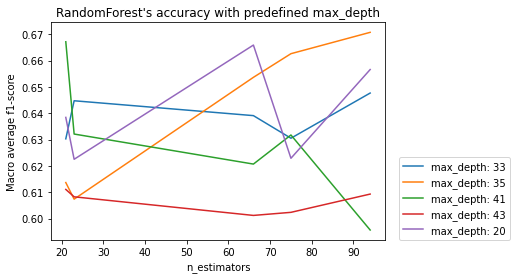

In [33]:
from utils.plot_utils import plot_score

macro_avg_f1_scores = dict(map(
    lambda z: (z, {'score': all_reports[z]['macro avg']['f1-score'][0],
                   'std': all_reports[z]['macro avg']['f1-score'][1]}),
    all_reports
))

plot_score(
    [macro_avg_f1_scores],
    ('n_estimators', 'max_depth'),
    'RandomForest',
    inverse=False,
    mode='score',
    in_same_graphic=True,
    accuracy_mode='accuracy',
    metric_name='Macro Average F1-Score'
)


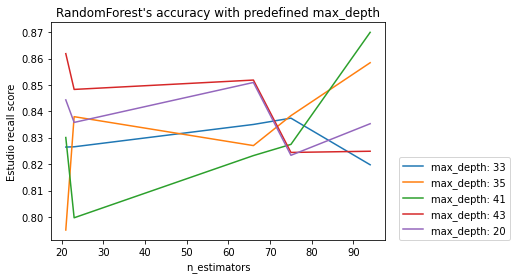

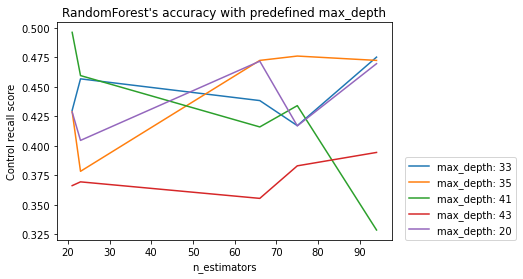

In [34]:
estudio_recall_scores = dict(map(
    lambda z: (z, {'score': all_reports[z]['Estudio']['recall'][0],
                   'std': all_reports[z]['Estudio']['recall'][1]}),
    all_reports
))

control_recall_scores = dict(map(
    lambda z: (z, {'score': all_reports[z]['Control']['recall'][0],
                   'std': all_reports[z]['Control']['recall'][1]}),
    all_reports
))

plot_score(
    [estudio_recall_scores],
    ('n_estimators', 'max_depth'),
    'RandomForest',
    inverse=False,
    mode='score',
    in_same_graphic=True,
    accuracy_mode='accuracy',
    metric_name='Estudio recall score'
)

plot_score(
    [control_recall_scores],
    ('n_estimators', 'max_depth'),
    'RandomForest',
    inverse=False,
    mode='score',
    in_same_graphic=True,
    accuracy_mode='accuracy',
    metric_name='Control recall score'
)


# <font color=#cd0000> Conclusiones </font>
- TODO